# SIT744 Practical 8: ConvNet Visualisation


*Dr Wei Luo*

<div class="alert alert-info">
We suggest that you run this notebook using Google Colab.
</div>


## Pre-practical readings

- [Visualizing what convnets learn](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.4-visualizing-what-convnets-learn.ipynb)


In the last lecture, we introduced three ways to visualise a trained ConvNet. In this practical, we will practice generating such visualisations using the cat-vs-dog example.








In [110]:
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()  # don't show any dataset loading process

TRAIN_DS_SIZE = 2000
VALID_DS_SIZE = 1000
TEST_DS_SIZE = 1000

(cat_dog_train, cat_dog_valid, cat_dog_test), info = tfds.load('cats_vs_dogs',
                                                               split=[f'train[:{TRAIN_DS_SIZE}]',
                                                                      f'train[{TRAIN_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE}]',
                                                                      f'train[{TRAIN_DS_SIZE + VALID_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE + TEST_DS_SIZE}]'],
                                                               with_info=True,
                                                               as_supervised=True)

## Task 1 Visualizing intermediate activations

We will first retrain a ConvNet for the dataset.

In [111]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers


IMAGE_SIZE = 150
def pre_process_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) ## Instead of manually scale the image, call a `tf.image` tool
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

TRAIN_BATCH_SIZE = 20
train_batches = cat_dog_train.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()
validation_batches = cat_dog_valid.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()



def make_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

  return model

model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [112]:
%%time

history = model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=50
      )

model.save('cats_and_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 7s 53ms/step - loss: 0.6902 - acc: 0.5305 - val_loss: 0.6916 - val_acc: 0.5130
Epoch 2/30
100/100 [==============================] - 2s 18ms/step - loss: 0.6780 - acc: 0.5610 - val_loss: 0.6774 - val_acc: 0.5300
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.6582 - acc: 0.6130 - val_loss: 0.6548 - val_acc: 0.5960
Epoch 4/30
100/100 [==============================] - 2s 16ms/step - loss: 0.6284 - acc: 0.6530 - val_loss: 0.6264 - val_acc: 0.6440
Epoch 5/30
100/100 [==============================] - 2s 17ms/step - loss: 0.5977 - acc: 0.6870 - val_loss: 0.6063 - val_acc: 0.6700
Epoch 6/30
100/100 [==============================] - 2s 17ms/step - loss: 0.5730 - acc: 0.7025 - val_loss: 0.5933 - val_acc: 0.6810
Epoch 7/30
100/100 [==============================] - 2s 17ms/step - loss: 0.5513 - acc: 0.7180 - val_loss: 0.5812 - val_acc: 0.6970
Epoch 8/30
100/100 [==============================] - 2s 18ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The model isn't perfect, as shown below.

1/1 [==============================] - 0s 16ms/step


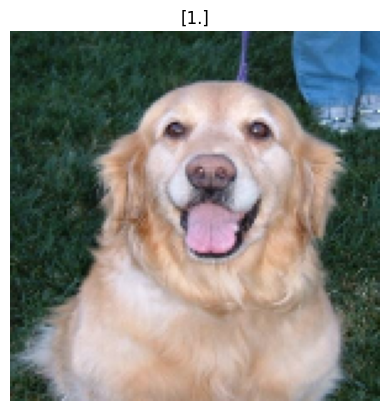

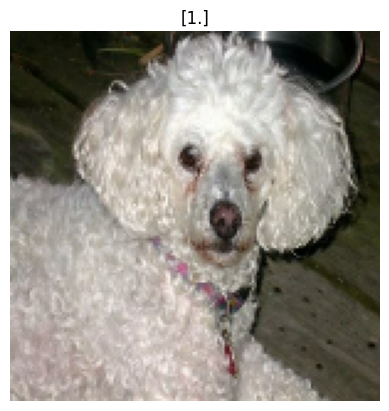

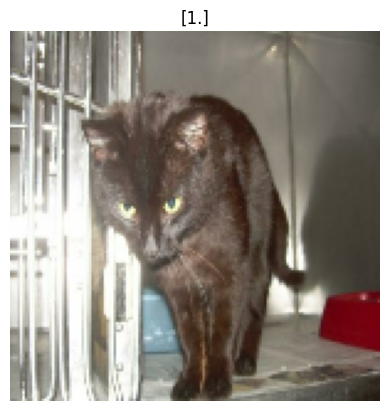

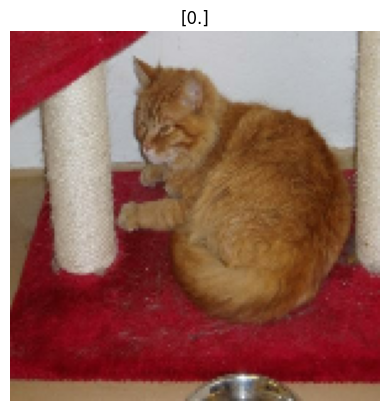

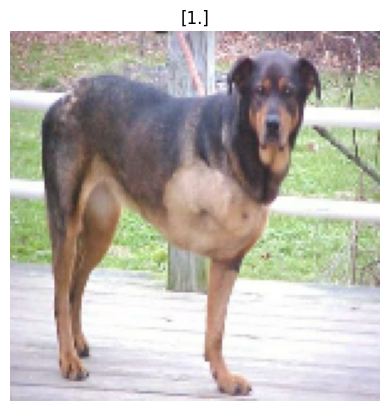

In [113]:
## Show the image and label
import matplotlib.pyplot as plt
import numpy as np

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')


for images, labels in cat_dog_test.map(pre_process_image).batch(1).take(5): # take first five examples
  predictions = model.predict(images)
  for image, prediction in zip(images, predictions):
    show(image, np.round(prediction))

Now we can visualise the model representations. First, let's define a multi-output network. The new network shares the same input layer, but outputs intermediate layers.

The input layer can be accessed as below.

In [114]:
model.input

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'conv2d_8_input')>

All the other layers can be accessed as follows.

In [115]:
model.layers

All the layers have been named by Keras.

In [116]:
[layer.name for layer in model.layers]

['conv2d_8',
 'max_pooling2d_8',
 'conv2d_9',
 'max_pooling2d_9',
 'conv2d_10',
 'max_pooling2d_10',
 'conv2d_11',
 'max_pooling2d_11',
 'flatten_2',
 'dense_4',
 'dense_5']

In [117]:
model= tf.keras.models.load_model('cats_and_dogs_small_1.h5')

We are interested in only convolutional layers and pooling layers.

In [118]:

# Extracts the outputs of the layers where '2d' is in the layer name :
layer_outputs = [layer.output for layer in model.layers if '2d' in layer.name]
print(layer_outputs)
# Creates a model that maps the activations of the layer_outputs
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)  ## list of 8 tensors

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_8')>, <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d_8')>, <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_9')>, <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_9')>, <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_10')>, <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_10')>, <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_11')>, <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_11')>]


Let's first look at the dog image correctly classified above.

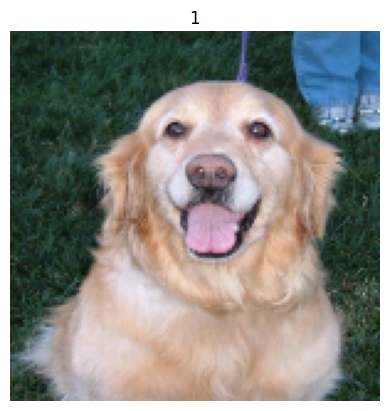

In [91]:
for image, label in cat_dog_test.map(pre_process_image).take(1):
  show(image, label.numpy())

Generate the intermediate activations.

In [119]:
for image, label in cat_dog_test.map(pre_process_image).take(1).batch(1):

  # one array per layer activation
  # print(image)
  activations = activation_model.predict(image)

1/1 [==============================] - 0s 67ms/step


In [120]:
print(len(activations)) ## list of 8 arrays

8


In [121]:
activations[0].shape

(1, 148, 148, 32)

Each output is a feature map, which contains a stack of 2D features.

(1, 148, 148, 32)


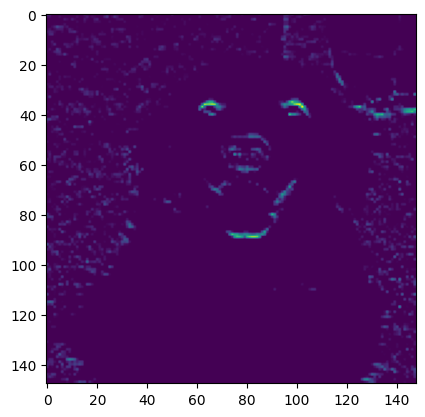

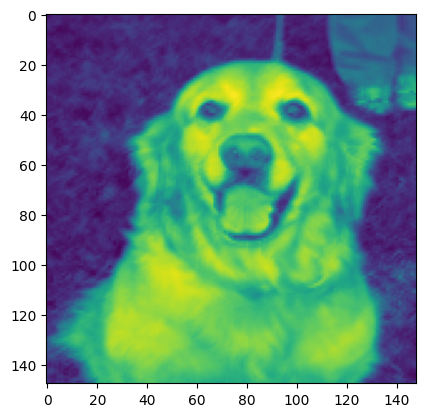

(1, 7, 7, 128)


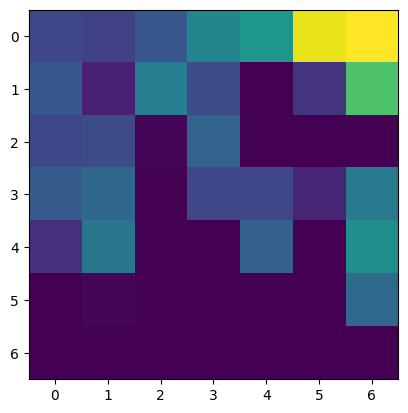

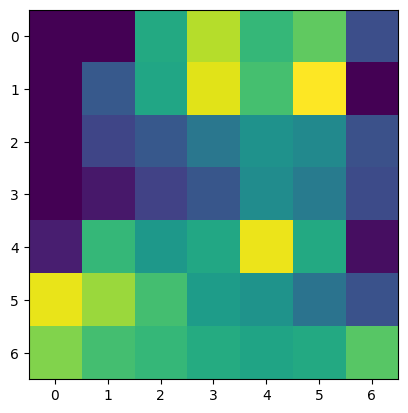

In [122]:
print(activations[0].shape) # The first feature map

plt.imshow(activations[0][0,:,:,0])     # feature map of the first filter in the first layer
plt.show()
plt.imshow(activations[0][0,:,:,31])   # feature map of the last filter in the first layer
plt.show()

print(activations[7].shape) # The last feature map
plt.imshow(activations[7][0,:,:,0])   # feature map of the first filter in the last layer
plt.show()
plt.imshow(activations[7][0,:,:,127])  # feature map of the last filter in the last layer
plt.show()

The following code shows all 8 feature maps.

<ipython-input-123-fcd1242bae3b>:26: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-123-fcd1242bae3b>:29: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')   ## values outside the interval [0,255] are clipped to the interval edges.    ################???????? why return to integer?


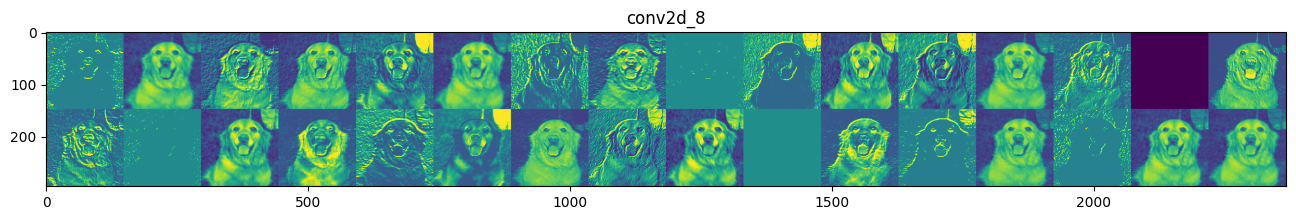

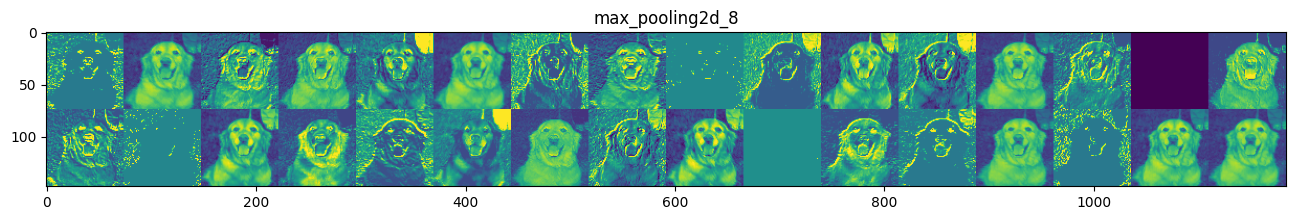

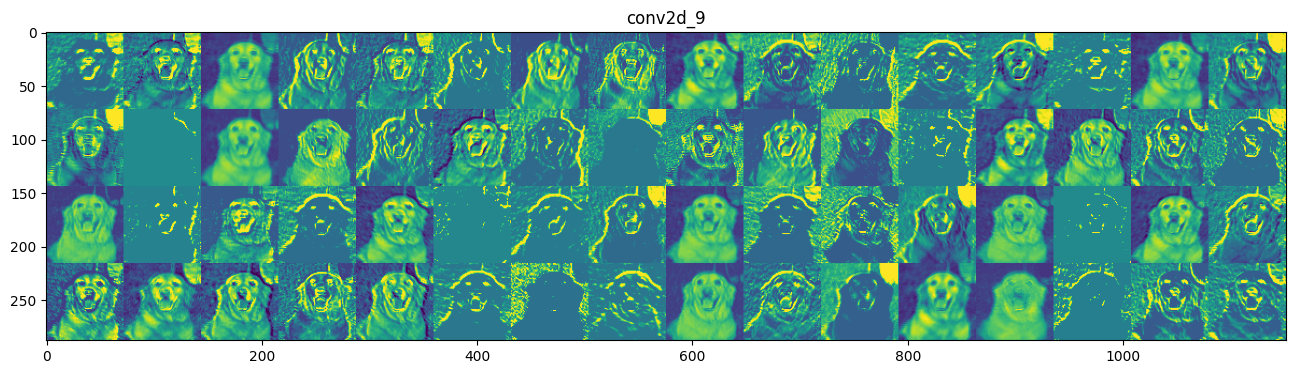

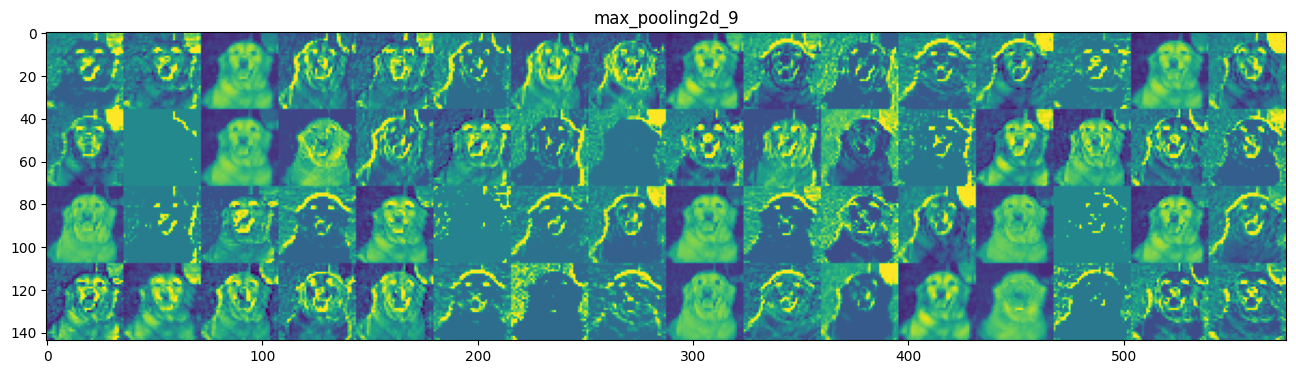

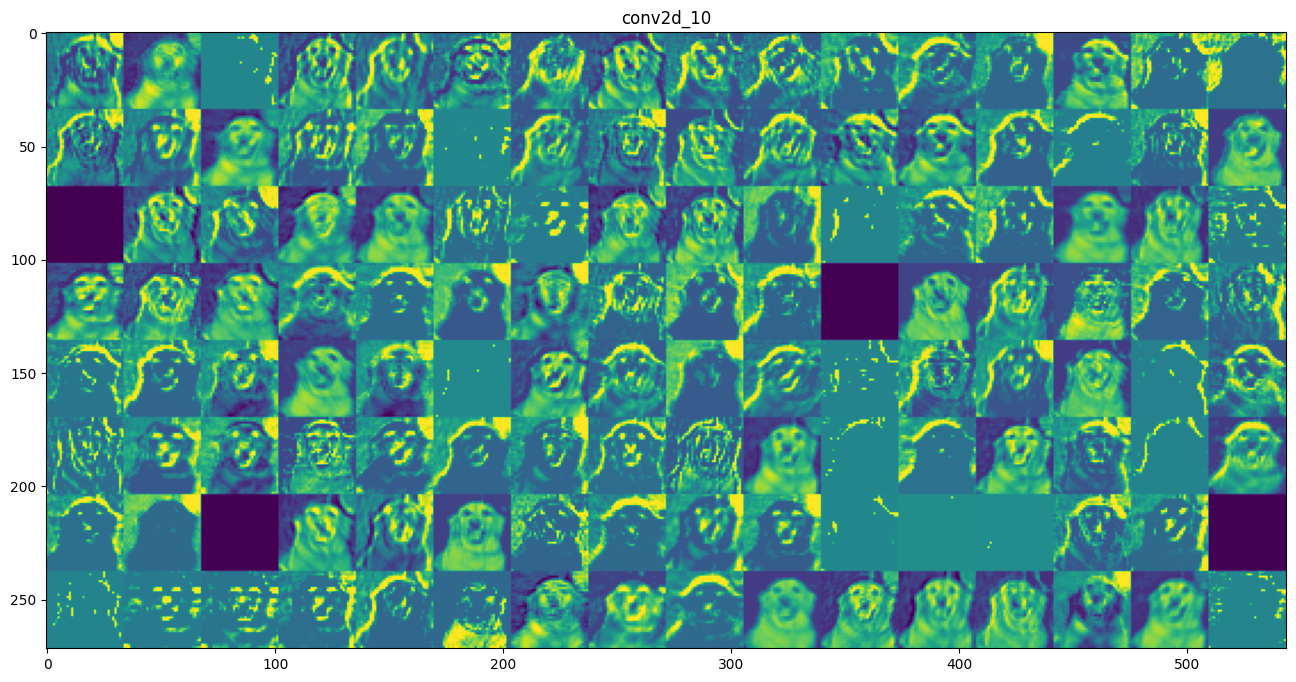

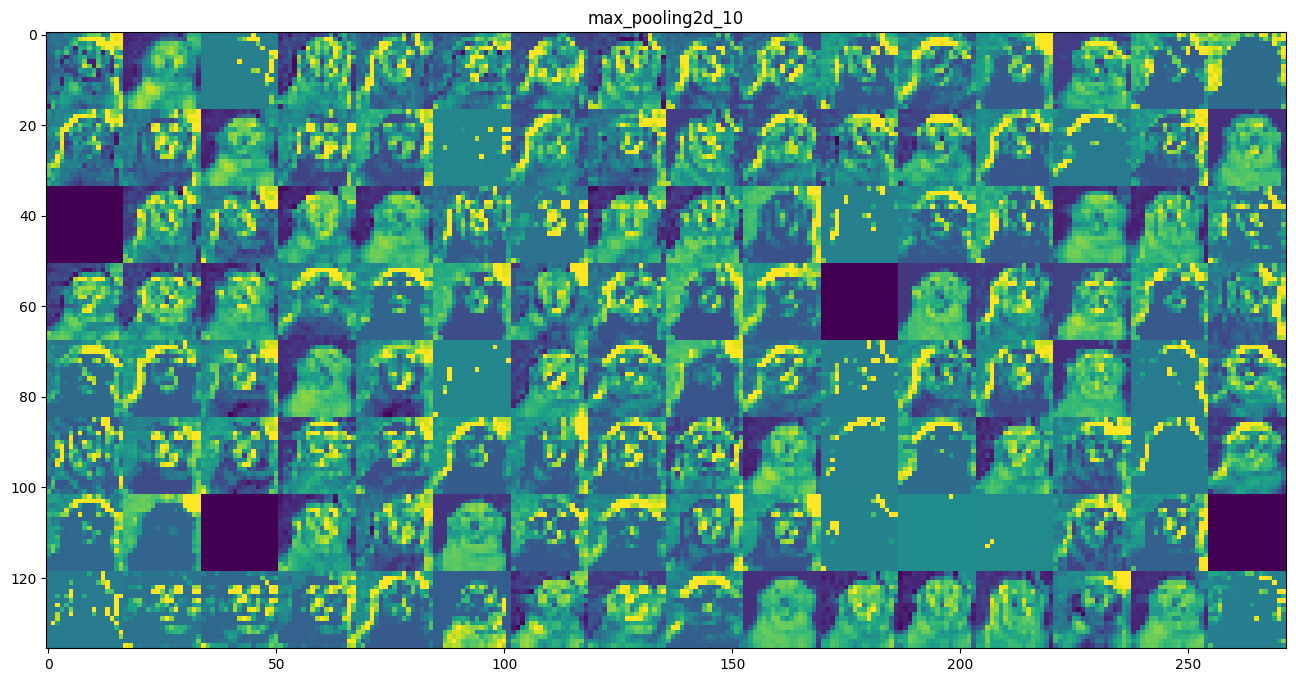

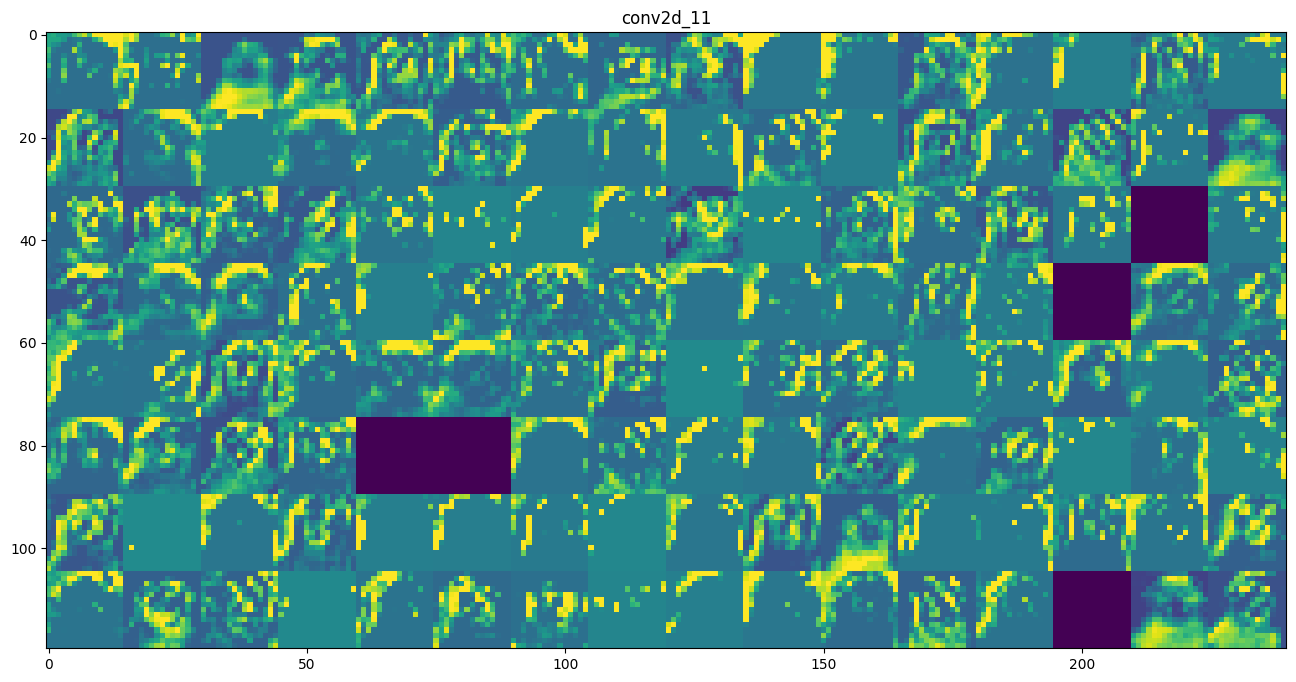

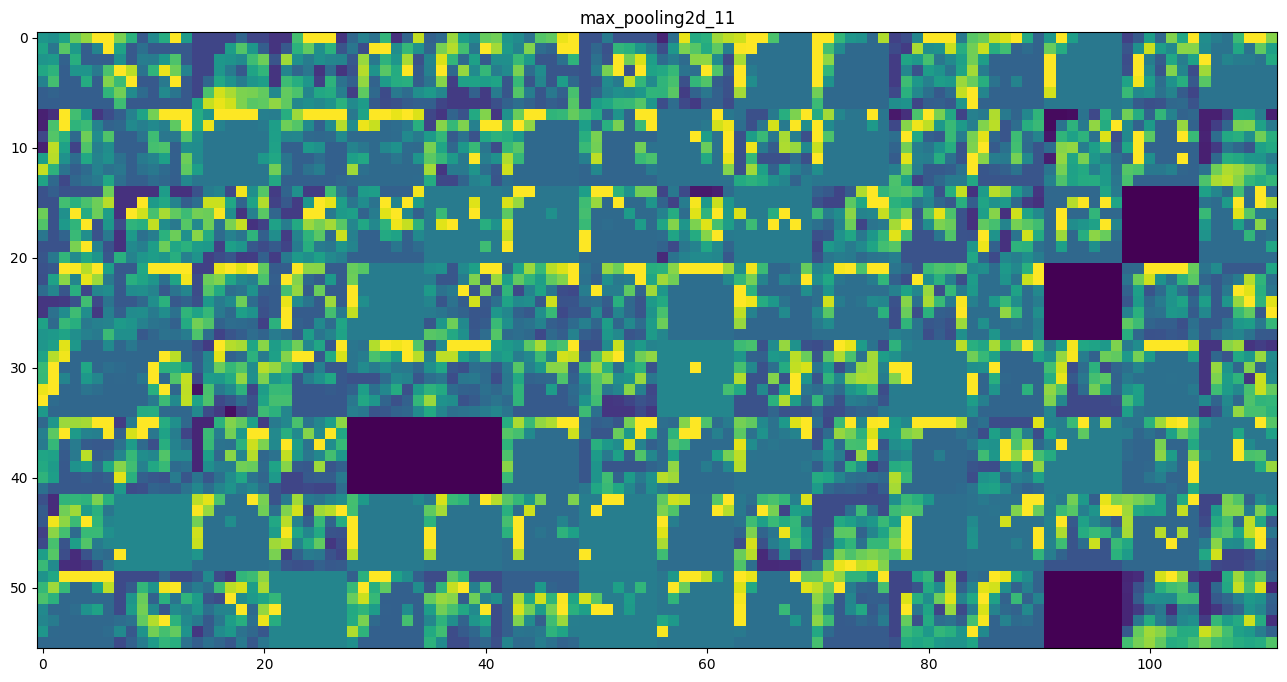

In [123]:
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers if '2d' in layer.name]

images_per_row = 16  # set the num of feature map

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations): # layer_activation shape:(1, size, size, n_features)

    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]   ## valuses: 32, 32, 64, 64, 128, 128, 128, 128
    # print(n_features)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]  # 148, 74, 72, 36, 34, 17, 15, 7

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row  # how many rows of feature maps can be visualized in the grid
    display_grid = np.zeros((size * n_cols, images_per_row * size))   # initialized to hold all images to be diplayed

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):  # nested loop is used to loop through all the filters
        for row in range(images_per_row):#(1, size, size, n_features)
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64   #enhance contrast in the image
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')   ## values outside the interval [0,255] are clipped to the interval edges.
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the activations of different filters from a convolutional layer into a grid layout
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()


**exercise** Feed in some other images in the test dataset. And visualise the feature maps. Do you see any difference between the activations for cat images and those for dog images?

## Task 2 Visualizing filters via gradient ascent

This type of visualisation does not depend on the input image. Given a filter (layer+channel), we aggregate the activation to produce the loss function. Note here we actually want to maximise the "loss".

In [124]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [125]:
model.layers[6].name

'conv2d_11'

In [126]:
from keras import backend as K

## select the target filter to visualise; filter is determined by layer and channel
layer_name = model.layers[6].name
filter_index = 127

layer_output = model.get_layer(layer_name).output # target layer

print(layer_output)

# Create a connection between the input and the target layer
submodel = models.Model(model.inputs, [layer_output])

print(model.inputs)
print([layer_output])

KerasTensor(type_spec=TensorSpec(shape=(None, 15, 15, 128), dtype=tf.float32, name=None), name='conv2d_11/Relu:0', description="created by layer 'conv2d_11'")
[<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'conv2d_8_input')>]
[<KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_11')>]


We start from a gray image with some noise and try to morph it into an image that maximally activate the target filter.

In [127]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

input_img_tensor = tf.Variable(tf.cast(input_img_data, tf.float32))  #convert datatype

This image will activate the filter.

In [128]:
# Do the forward computation
with tf.GradientTape() as tape:
  outputs = submodel(input_img_tensor)  # shape is (1, 15, 15, 128)
  print(outputs.shape)
  print(outputs[0].shape)
  activation_value = tf.reduce_mean(outputs[ :, :, :, filter_index]) # Reduce the activation to one number across the dimensions in axis
print(activation_value)
grads = tape.gradient(activation_value, input_img_tensor)
print("")
print(grads.shape)

(1, 15, 15, 128)
(15, 15, 128)
tf.Tensor(46.25648, shape=(), dtype=float32)

(1, 150, 150, 3)


Here the input will be the parameters to tune. Like before, we normalise the gradients.

In [129]:
normalized_grads = \
    grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5) # Add a small costant at the end to avoid divisions by 0

step_size = 1.0 # step size of gradient ascent

input_img_tensor.assign_add(normalized_grads * step_size)

<tf.Variable 'UnreadVariable' shape=(1, 150, 150, 3) dtype=float32, numpy=
array([[[[139.3086 , 141.78084, 141.64197],
         [136.29817, 142.10072, 131.36058],
         [146.13878, 129.83554, 134.04129],
         ...,
         [142.83586, 139.38988, 145.29027],
         [143.66533, 138.49857, 147.82281],
         [129.78032, 129.47458, 147.28365]],

        [[139.87488, 140.8622 , 131.45161],
         [138.85168, 140.79712, 144.98434],
         [133.859  , 136.71112, 144.82904],
         ...,
         [139.31367, 141.02438, 143.23271],
         [131.47966, 134.12045, 134.4099 ],
         [138.37846, 131.03064, 139.85019]],

        [[134.08592, 137.54016, 146.96506],
         [130.08388, 139.05055, 134.13885],
         [144.29451, 139.12863, 128.8281 ],
         ...,
         [134.43915, 146.84843, 145.27806],
         [141.98918, 129.10924, 144.4038 ],
         [143.84875, 146.21074, 145.48073]],

        ...,

        [[133.7788 , 145.00229, 134.76566],
         [131.94179, 128.79

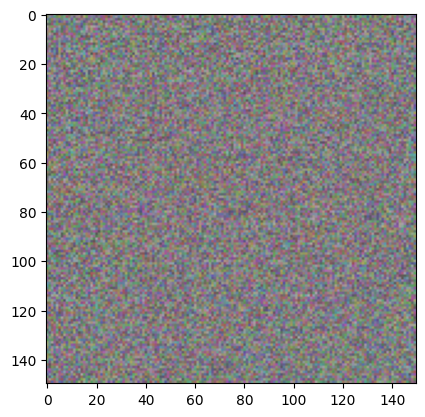

In [130]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

plt.imshow(deprocess_image(input_img_tensor[0].numpy() ))
plt.show()

Not much to see here. But let's repeat this 400 times, continuing gradient ascent from this image.

In [131]:
for _ in range(400):
  with tf.GradientTape() as tape:
    outputs = submodel(input_img_tensor)
    loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])

  grads = tape.gradient(loss_value, input_img_tensor)
  normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
  input_img_tensor.assign_add(normalized_grads * step_size)


After 400 steps, the random image becomes an image that will result in high activation at the target filter.

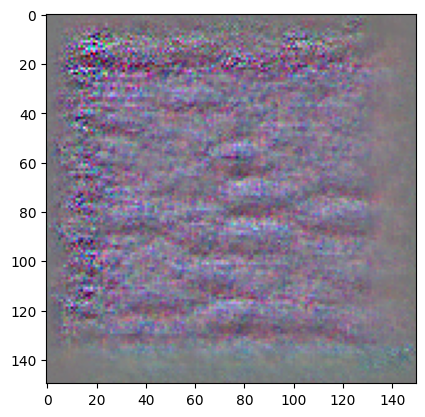

In [132]:
plt.imshow(deprocess_image(input_img_tensor[0].numpy()))
plt.show()

Because we trained a relatively shallow model with a relatively small training dataset, the filters are not unnecessarily very interpretable.

**exercise**

1. Retrain your model with data augmentation, and then visualise the filter banks in the retrained model.
2. Load a model pretrained with ImageNet and visualise the filters in the model.

## Task 3 Class Activation Map (CAM) visualization



Class Activation Map (CAM) is used to generate a heatmap highlighting the part of the input image influencing the model's classification decision. We will base the heatmap on the last layer feature map. With the risk of over-simplification, you may consider the method is to look for regions that are most positively correlated with the prediction.

In [133]:
last_conv_layer = model.layers[6]
layer_output = last_conv_layer.output  # capture the activation of the last con layer

# Create a connection between the input and the target layer
submodel2 = models.Model(model.inputs, [layer_output, model.output])  # we need the activation and prediction of the target layer

We have a binary output node, with 1 for 'dog' and 0 for 'cat'. We can define the gradients of the output node (the probability of 'dog') over the feature map.

In [134]:
for image, label in cat_dog_test.map(pre_process_image).take(1).batch(1):
  with tf.GradientTape() as tape:
    conv_output, predictions = submodel2(image)
    print(predictions)
    print("")
    print(predictions[0])
    prediction = predictions[0]

#compute the gradient of the selected prediction with respect to the convolutional layer outputs.
#aim: How much each partt of the con layer' output contributes to the final prediction
print("prediction:", prediction.shape)
print("conv_output:", conv_output.shape)
# print("original:",tape.gradient(prediction, conv_output).shape) # original_shape: (1, 15, 15, 128)
grads = tape.gradient(prediction, conv_output)[0]

tf.Tensor([[0.9999242]], shape=(1, 1), dtype=float32)

tf.Tensor([0.9999242], shape=(1,), dtype=float32)
prediction: (1,)
conv_output: (1, 15, 15, 128)


In [135]:
grads.shape

TensorShape([15, 15, 128])

For each feature, we need only one number as the channel weight.

In [136]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  #Reduce the grads to one number across the dimensions in axis to get the average of gradients values
pooled_grads.shape

TensorShape([128])

Next, we use the weights to aggregate the activations of different features.  

In [137]:
#use grads as weights, compute the weighted average
cam = tf.multiply(conv_output[0], pooled_grads)

heatmap = np.mean(cam, axis=-1)

It can be normalised between 0 and 1.


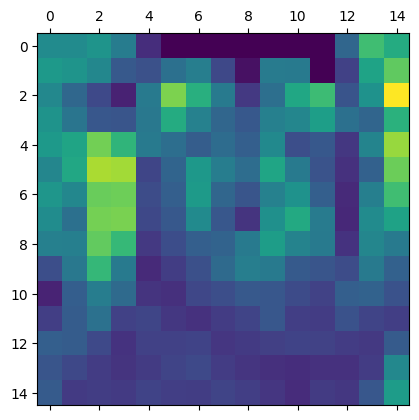

In [138]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we superimpose the heatmap over the original image.

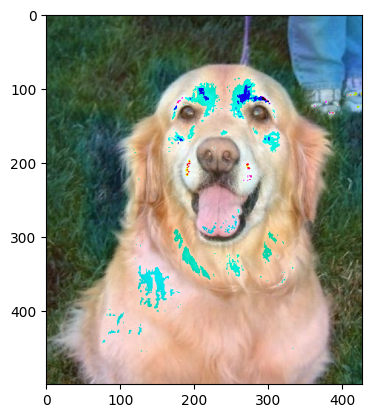

In [139]:
import cv2

img, _ = next(iter(cat_dog_test)) #reload the image, without normalisation

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.1 + img
plt.imshow(superimposed_img)

The visualisation seems to suggest that the areas surrounding the eyes and the tongue led to the image being classified as dog.

**exercise** Try to produce a CAM heatmap visualisation with the pretrained VGG16 model downloaded from `keras.applications`.

## Additional resources

- [tf-explain](https://github.com/sicara/tf-explain)